#### The test_pid_model ipnb file calculates the accuracy of the model bounding box and label prediction using Mean square error and percentage based accuracy.

In [1]:
import io
import os
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow

class_area = {'21': 1985, '2': 5415, '18': 6969, '26': 17849, '8': 7037, '20': 6110, '25': 6532, '32': 16411, '28': 17179, '7': 6771, '9': 6689, '12': 5510, '22': 5795, '24': 2808, '11': 6129, '23': 8645, '29': 17181, '4': 6132, '31': 16001, '5': 4808, '15': 3737, '17': 5721, '19': 6769, '30': 11940, '16': 3564, '13': 6558, '1': 4575, '6': 3126, '10': 8179, '27': 18761, '14': 13607, '3': 6903}


TEST_DATASET_PATH = "D:/Veilex/_test/train-segment-data/datasets/custom_dataset/dataset/test"
FULL_TEST_DATASET_PATH="D:/Veilex/_test/dataset/DigitizePID_Dataset"
images_dir = "images"
labels_dir = "labels"

# the file id for the model in google dirve
MODEL_FILE_ID = "1rd0GmerO8wzWBcAr5e38_WOXYLJqTDKl"
model_file_id = MODEL_FILE_ID

In [2]:
SCOPES = ["https://www.googleapis.com/auth/drive"]

CREDENTIAL_FILE_NAME = "../credentials.json"
TOKEN_FILE_NAME = "../token.json"

def download_file(file_id, credential_file_name: str):
    file = None
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists(TOKEN_FILE_NAME):
        creds = Credentials.from_authorized_user_file(TOKEN_FILE_NAME, SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                credential_file_name, SCOPES
            )
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open(TOKEN_FILE_NAME, "w") as token:
            token.write(creds.to_json())

    try:
        # create drive api client
        service = build("drive", "v3", credentials=creds)

        request = service.files().get_media(fileId=file_id)
        file = io.BytesIO()
        downloader = MediaIoBaseDownload(file, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(f"Download {int(status.progress() * 100)}.")

    except HttpError as error:
        print(f"An error occurred: {error}")
        file = None

    return file.getvalue()

yolo_model_pid_bytes = download_file(file_id=model_file_id, credential_file_name=CREDENTIAL_FILE_NAME)

Download 100.


In [3]:
from ultralytics import YOLO

model_file_path = "yolo-model-pid.pt"

# testing if model can be loaded.
if not os.path.exists(model_file_path):
    with open(model_file_path, 'wb') as f:
        f.write(yolo_model_pid_bytes)

model = YOLO(model_file_path)

In [4]:
from typing import List, Tuple
from PIL import Image

from src.models import Vertex, PidDataPoint, Symbol
from src.utils import denormalize_coordinates

# this is a YOLO formatted based dataset that has to be extracted from the directory.
def read_yolo_label_data(label_path: str) -> List[Tuple[str, float, float, float, float]]:
    with open(label_path, 'r') as file:
        lines = file.readlines()

    labels = []
    for line in lines:
        class_id, x, y, _x, _y = line.strip().split()
        labels.append((class_id, float(x), float(y), float(_x), float(_y)))
    return labels
    

pid_test_dataset = []

dataset_images_path = f"{TEST_DATASET_PATH}/{images_dir}"
dataset_labels_path = f"{TEST_DATASET_PATH}/{labels_dir}"
image_files = [os.path.join(dataset_images_path, f) for f in os.listdir(dataset_images_path) if os.path.isfile(os.path.join(dataset_images_path, f))]

for image_file_path in image_files:
    datapoint = PidDataPoint(
        image_path=image_file_path
    )
    image = Image.open(image_file_path)
    image_file_name = '.'.join(image_file_path.split("\\")[-1].split(".")[0:-1])
    label_dp_path = os.path.join(dataset_labels_path, f"{image_file_name}.txt")
    if os.path.isfile(label_dp_path):
        yolo_datalabel = read_yolo_label_data(label_dp_path)
        symbols = []
        for l in yolo_datalabel:
            class_id, x, y, _x, _y = l
            x, y, _x, _y = denormalize_coordinates([x, y, _x, _y], image.width, image.height)
            symbols.append(
                Symbol(
                    label=class_id,
                    name="",
                    pointSrc=Vertex(x=x, y=y),
                    pointDest=Vertex(x=_x, y=_y)
                )
            )
        datapoint.symbols = symbols
    
    pid_test_dataset.append(datapoint)


In [32]:
from src.services import PredictSymbolsService


def predict_results():
    predicted_results = []
    for index, d in enumerate(pid_test_dataset[:100]):
        predict_service = PredictSymbolsService(
            image_path=d.image_path,
            model_path=model_file_path
        )

        bboxes_with_labels = predict_service.predict_bounding_boxes()
        predicted_results.append(bboxes_with_labels)

    return predicted_results

predicted_results: List[List[Tuple[List[int], str]]] = predict_results()


0: 1088x1088 1 14, 1 21, 1 32, 101.2ms
Speed: 4.6ms preprocess, 101.2ms inference, 0.5ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish prediction: 0.17082595825195312

0: 1088x1088 1 3, 3 5s, 1 9, 1 10, 1 15, 1 21, 1 25, 2 28s, 1 32, 83.4ms
Speed: 17.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish prediction: 0.14789915084838867

0: 1088x1088 1 2, 1 4, 1 22, 1 28, 1 31, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish prediction: 0.1611042022705078

0: 1088x1088 1 8, 1 12, 1 19, 1 21, 1 22, 1 25, 1 26, 1 29, 95.5ms
Speed: 5.0ms preprocess, 95.5ms inference, 0.1ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish prediction: 0.16308259963989258

0: 1088x1088 1 5, 1 20, 1 21, 75.6ms
Speed: 5.0ms preprocess, 75.6ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish predi

In [33]:
predicted_results

[[([879.8729858398438,
    378.10687255859375,
    994.6038818359375,
    505.20648193359375],
   '14'),
  ([849.8284912109375, 59.3841438293457, 979.2515258789062, 187.4505615234375],
   '32'),
  ([536.8956909179688,
    378.14776611328125,
    569.3073120117188,
    440.0269470214844],
   '21')],
 [([595.19970703125, 540.6663208007812, 712.1820678710938, 628.8284301757812],
   '10'),
  ([634.0052490234375,
    257.3110046386719,
    718.8758544921875,
    321.0689392089844],
   '3'),
  ([304.5430603027344, 828.1495361328125, 406.88311767578125, 888.46044921875],
   '5'),
  ([371.85748291015625,
    523.3359985351562,
    470.7179260253906,
    622.8003540039062],
   '25'),
  ([87.47782135009766,
    542.0814208984375,
    165.71351623535156,
    603.7669677734375],
   '5'),
  ([508.541259765625, 370.6865539550781, 579.7445068359375, 474.6044616699219],
   '9'),
  ([614.0078125, 799.4119873046875, 734.4483032226562, 917.1216430664062],
   '28'),
  ([893.9596557617188,
    222.93634033

In [34]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# mean square error calculation w.r.t the bounding boxes.

def mean_square_error_with_matching(actual_boxes, predicted_boxes) -> float:
    """
    Calculate the mean square error (MSE) between actual and predicted bounding boxes,
    accounting for mismatched order by using optimal matching (Hungarian algorithm).
    
    Parameters:
    actual_boxes: List of actual bounding boxes [(x1, y1, x2, y2), ...]
    predicted_boxes: List of predicted bounding boxes [(x1, y1, x2, y2), ...]

    Returns:
    float: Mean square error value
    """

    if len(actual_boxes) > len(predicted_boxes):
        for _ in range(abs(len(actual_boxes) - len(predicted_boxes))):
            predicted_boxes.append([0, 0, 0, 0])
    
    if len(predicted_boxes) > len(actual_boxes):
        for _ in range(abs(len(actual_boxes) - len(predicted_boxes))):
            actual_boxes.append([0, 0, 0, 0])

    if len(actual_boxes) != len(predicted_boxes):
        raise ValueError("The number of actual and predicted boxes must be the same.")
    
    # Convert to numpy arrays for efficient computation
    actual_boxes = np.array(actual_boxes)
    predicted_boxes = np.array(predicted_boxes)
    
    # Compute the cost matrix (pairwise squared errors)
    cost_matrix = np.zeros((len(actual_boxes), len(predicted_boxes)))
    for i, actual in enumerate(actual_boxes):
        for j, predicted in enumerate(predicted_boxes):
            cost_matrix[i, j] = np.mean((actual - predicted) ** 2)
    
    # Solve the assignment problem using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Calculate the total MSE based on the optimal assignment
    mse = 0.0
    for i, j in zip(row_ind, col_ind):
        mse += cost_matrix[i, j]
    
    mse /= len(actual_boxes)
    return mse

def bbox_area_valid(annotation_prediction):
    bbox = annotation_prediction[0]
    class_id = annotation_prediction[1]
    predicted_area = (abs(bbox[0] - bbox[2])) * (abs(bbox[1] - bbox[3]))
    return predicted_area > class_area[class_id] * 0.6

# mean squre error in testing the images with symbols
def calculate_test_pid_mse():
    no_of_test_data = len(predicted_results)
    not_including_in_testing = 0
    sum = 0
    for index, d in enumerate(predicted_results):
        # filtered_result = [bl for bl in d if bbox_area_valid(bl)] # [bl[0] for bl in d]
        predicted_bboxes = [bl[0] for bl in d] # [bl[0] for bl in filtered_result] 
        actual_bboxes = []
        for s in pid_test_dataset[index].symbols:
            x, y = s.pointSrc.get_dimensions()
            _x, _y = s.pointDest.get_dimensions()
            actual_bboxes.append([x, y, _x, _y])
        
        mse = 0
        try:
            mse += mean_square_error_with_matching(actual_bboxes, predicted_bboxes)
        except:
            not_including_in_testing += 1
            print(f"could not caculate MSE of the datapoint {index}") 

        sum += mse
    print("not included in dataset ", not_including_in_testing)
    print("Mean Square Error, ", sum / (no_of_test_data - not_including_in_testing))

calculate_test_pid_mse()

not included in dataset  0
Mean Square Error,  74728.49691594327


In [35]:
import numpy as np
from scipy.optimize import linear_sum_assignment


# accuracy of dataset w.r.t the bounding boxes.

def calculate_iou(box1, box2) -> float:
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    box1, box2: (x1, y1, x2, y2)
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Compute the area of the intersection rectangle
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Compute the area of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Compute the union area
    union_area = box1_area + box2_area - inter_area
    
    # Compute IoU
    return inter_area / union_area if union_area != 0 else 0

def accuracy_with_iou(actual_boxes, predicted_boxes, iou_threshold=0.5) -> float:
    """
    Calculate the percentage accuracy of the predicted bounding boxes using IoU.
    
    Parameters:
    actual_boxes: List of actual bounding boxes [(x1, y1, x2, y2), ...]
    predicted_boxes: List of predicted bounding boxes [(x1, y1, x2, y2), ...]
    iou_threshold: IoU threshold to consider a match as correct
    
    Returns:
    float: Accuracy percentage
    """
    if len(actual_boxes) > len(predicted_boxes):
        for _ in range(abs(len(actual_boxes) - len(predicted_boxes))):
            predicted_boxes.append([0, 0, 0, 0])
    
    if len(predicted_boxes) > len(actual_boxes):
        for _ in range(abs(len(actual_boxes) - len(predicted_boxes))):
            actual_boxes.append([0, 0, 0, 0])

    if len(actual_boxes) != len(predicted_boxes):
        raise ValueError("The number of actual and predicted boxes must be the same.")
    
    # Compute the IoU cost matrix
    cost_matrix = np.zeros((len(actual_boxes), len(predicted_boxes)))
    for i, actual in enumerate(actual_boxes):
        for j, predicted in enumerate(predicted_boxes):
            cost_matrix[i, j] = -calculate_iou(actual, predicted)  # Negate for maximization
    
    # Solve the assignment problem using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Count correct matches based on the IoU threshold
    correct_matches = 0
    for i, j in zip(row_ind, col_ind):
        iou = -cost_matrix[i, j]  # Undo the negation
        if iou >= iou_threshold:
            correct_matches += 1
    
    # Compute accuracy
    accuracy = (correct_matches / len(actual_boxes)) * 100
    return accuracy

# percentage accuracy of PID
def calculate_test_pid_accuracy():
    no_of_test_dataset = len(predicted_results)
    not_including_in_testing = 0
    sum = 0
    for index, d in enumerate(predicted_results):
        # predict_service = PredictSymbolsService(
        #     image_path=d.image_path,
        #     model_path=model_file_path
        # )

        # bboxes_with_labels = predict_service.predict_bounding_boxes()
        predicted_bboxes = [bl[0] for bl in d]

        actual_bboxes = []
        for s in pid_test_dataset[index].symbols:
            x, y = s.pointSrc.get_dimensions()
            _x, _y = s.pointDest.get_dimensions()
            actual_bboxes.append([x, y, _x, _y])
        
        accuracy = 0
        try:
            accuracy += accuracy_with_iou(actual_bboxes, predicted_bboxes)
        except:
            not_including_in_testing += 1
            print(f"Could not test MSE of the datapoint {index}") 

        sum += accuracy

    print("Accuracy")
    print(sum / (no_of_test_dataset - not_including_in_testing))
    print("datapoints not included in testing ", not_including_in_testing)

calculate_test_pid_accuracy()

Accuracy
78.45057997557997
datapoints not included in testing  0


In [47]:
# calculation of label accuracy with the segmented dataset.

def calculate_label_accuracy(predicted_result_set, actrual_dataset):
    sum_accuracy = 0
    pid_test_dataset = actrual_dataset
    for index, d in enumerate(predicted_result_set):
        predicted_labels = [x[1] for x in d]
        actual_symbol_labels = [s.label for s in pid_test_dataset[index].symbols]
        s_dict = {}
        for s in actual_symbol_labels:
            if(s not in s_dict):
                s_dict[s] = 1
            else:
                s_dict[s] += 1

        for s in predicted_labels:
            if(s in s_dict):
                s_dict[s] -= 1

        incorrect_result_sum = sum([abs(val) for val in s_dict.values()])

        sum_accuracy += ((len(actual_symbol_labels) - incorrect_result_sum) / len(actual_symbol_labels))

    return sum_accuracy / len(predicted_result_set)

[PidDataPoint(symbols=[Symbol(name='', pointSrc=Vertex(x=536.0, y=378.0), pointDest=Vertex(x=569.0, y=440.0), label='21'), Symbol(name='', pointSrc=Vertex(x=880.0, y=379.0), pointDest=Vertex(x=994.0, y=506.0), label='14'), Symbol(name='', pointSrc=Vertex(x=851.0, y=60.0), pointDest=Vertex(x=978.0, y=187.0), label='32')], lines=[], words=[], image_path='D:/Veilex/_test/train-segment-data/datasets/custom_dataset/dataset/test/images\\425.jpg.chunk_2_3.png'),
 PidDataPoint(symbols=[Symbol(name='', pointSrc=Vertex(x=610.0, y=800.0), pointDest=Vertex(x=737.0, y=916.0), label='28'), Symbol(name='', pointSrc=Vertex(x=304.0, y=828.0), pointDest=Vertex(x=406.0, y=888.0), label='5'), Symbol(name='', pointSrc=Vertex(x=792.0, y=678.0), pointDest=Vertex(x=856.0, y=740.0), label='15'), Symbol(name='', pointSrc=Vertex(x=634.0, y=258.0), pointDest=Vertex(x=719.0, y=321.0), label='3'), Symbol(name='', pointSrc=Vertex(x=35.0, y=222.0), pointDest=Vertex(x=167.0, y=354.0), label='28'), Symbol(name='', poin

### Testing the accuracy on full images

In [54]:
pid_dataset_path = "D:/Veilex/_test/dataset/DigitizePID_Dataset"
from config import config
from src.services import DataConverterService, PredictSymbolsService

# change the config here. This should not be done anywhere else btw, this is exception
config.dataset_path = pid_dataset_path
config.image_dir_name = "image_2"
config.annotation_dir_name = "annotations"

data_service = DataConverterService()
full_pid_dataset = data_service.load_dataset()

def predict_full_dataset_results():
    predicted_results = []
    for d in full_pid_dataset[0:20]:
        predict_service = PredictSymbolsService(
            image_path=d.image_path,
            model_path=model_file_path
        )

        bboxes_with_labels = predict_service.predict_bounding_boxes(shifting=True)
        predicted_results.append(bboxes_with_labels)

    return predicted_results

predicted_full_results: List[PidDataPoint] = predict_full_dataset_results()
    


0: 1088x1088 (no detections), 90.1ms
Speed: 14.8ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 1 9, 98.4ms
Speed: 0.0ms preprocess, 98.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 1 2, 1 8, 1 11, 1 12, 1 20, 1 21, 1 24, 2 25s, 101.9ms
Speed: 0.0ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 (no detections), 92.6ms
Speed: 3.9ms preprocess, 92.6ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 224x1088 (no detections), 38.0ms
Speed: 1.1ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 1088)

0: 1088x1088 1 12, 3 21s, 2 22s, 1 26, 101.0ms
Speed: 7.4ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 1 2, 1 12, 1 18, 1 20, 2 21s, 1 22, 2 26s, 1 29, 100.9ms
Speed: 0.0ms preprocess, 100.9ms inference, 0.0ms postprocess per image at sh

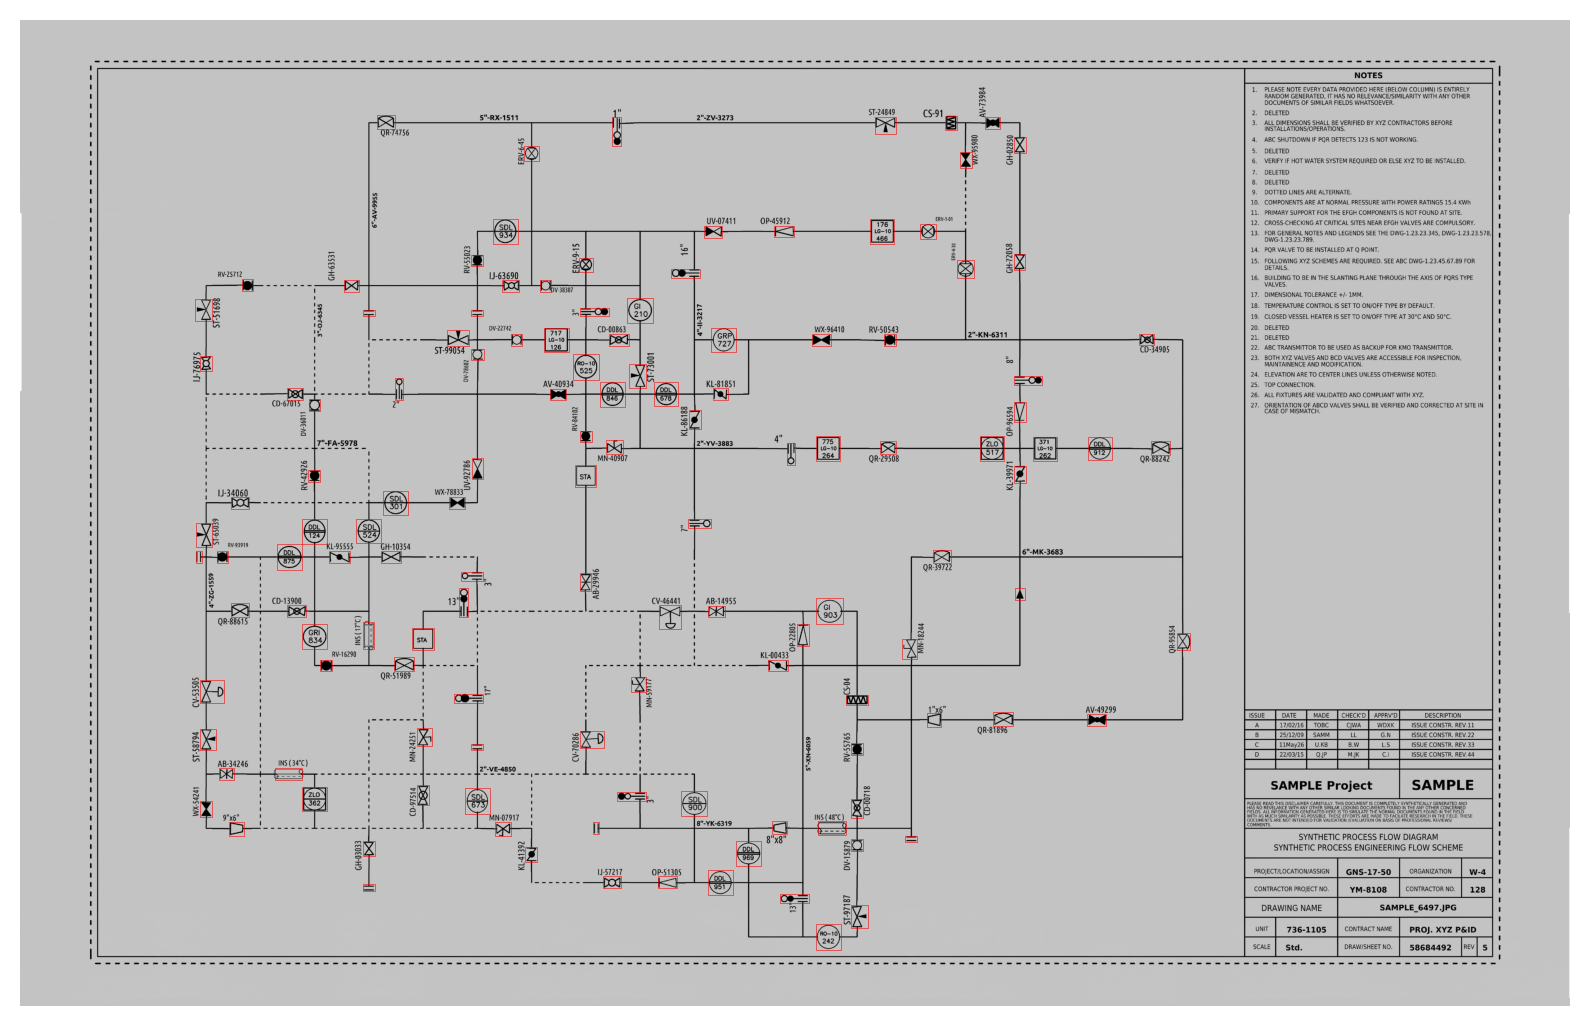

In [56]:
from src.utils import convert_points_to_bounding_box
from src.services import ImageDisplayService

index_to_select = 9

instance = predicted_full_results[index_to_select]
service = ImageDisplayService(
    image_path=full_pid_dataset[index_to_select].image_path,
    bounding_boxes=[convert_points_to_bounding_box(i[0]) for i in instance ]
)

service.display_image_with_bbox()

In [57]:
def calculate_full_pid_dataset_accuracy():
    not_including_in_testing = 0
    sum = 0
    for index, d in enumerate(predicted_full_results):
        predicted_bboxes = [bl[0] for bl in d]

        actual_bboxes = []
        for s in full_pid_dataset[index].symbols:
            x, y = s.pointSrc.get_dimensions()
            _x, _y = s.pointDest.get_dimensions()
            actual_bboxes.append([x, y, _x, _y])
        
        accuracy = 0
        try:
            print( len(actual_bboxes), len(predicted_bboxes) )
            accuracy += accuracy_with_iou(actual_bboxes, predicted_bboxes)
        except:
            not_including_in_testing += 1
            print(f"Could not test MSE of the datapoint {index}") 

        sum += accuracy

    print("Accuracy")
    print(sum / (len(predicted_full_results) - not_including_in_testing))
    print("datapoints not included in testing ", not_including_in_testing)

calculate_full_pid_dataset_accuracy()

90 90
92 92
105 106
121 121
105 104
119 118
105 104
115 114
119 119
131 131
107 107
114 114
115 114
107 106
143 142
172 171
171 171
168 167
149 149
152 152
Accuracy
99.51251923214537
datapoints not included in testing  0


In [58]:
calculate_label_accuracy(predicted_full_results, full_pid_dataset[0:20])

0.9950361023610427

10